# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
%pip install torchvision --user

     |████████████████████████████████| 12.8MB 7.1MB/s eta 0:00:01
     |████████████████████████████████| 776.8MB 14kB/s s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# TODO: Make all other necessary imports.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import json
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import PIL
import json
from PIL import Image
import seaborn
import glob,random
print("Imported required packages")

Imported required packages


In [2]:
import zipfile
with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('flowers_new')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [4]:
# Download data to default local directory "~/tensorflow_datasets"
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102
#skip the above command as flowers are copied into workspace

## Explore the Dataset

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [7]:
with open('label_map.json', 'r') as f:
    label_map = json.load(f)

In [8]:
print(json.dumps(label_map, indent=2, sort_keys=True))

{
  "1": "pink primrose",
  "10": "globe thistle",
  "100": "blanket flower",
  "101": "trumpet creeper",
  "102": "blackberry lily",
  "11": "snapdragon",
  "12": "colt's foot",
  "13": "king protea",
  "14": "spear thistle",
  "15": "yellow iris",
  "16": "globe-flower",
  "17": "purple coneflower",
  "18": "peruvian lily",
  "19": "balloon flower",
  "2": "hard-leaved pocket orchid",
  "20": "giant white arum lily",
  "21": "fire lily",
  "22": "pincushion flower",
  "23": "fritillary",
  "24": "red ginger",
  "25": "grape hyacinth",
  "26": "corn poppy",
  "27": "prince of wales feathers",
  "28": "stemless gentian",
  "29": "artichoke",
  "3": "canterbury bells",
  "30": "sweet william",
  "31": "carnation",
  "32": "garden phlox",
  "33": "love in the mist",
  "34": "mexican aster",
  "35": "alpine sea holly",
  "36": "ruby-lipped cattleya",
  "37": "cape flower",
  "38": "great masterwort",
  "39": "siam tulip",
  "4": "sweet pea",
  "40": "lenten rose",
  "41": "barbeton daisy"

In [9]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

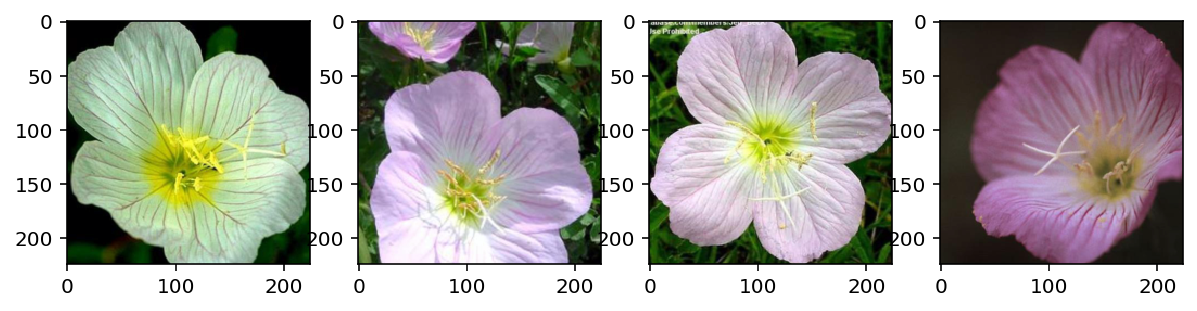

In [10]:
# Display a few images
data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
loader = torch.utils.data.DataLoader(data, batch_size=64)
images, labels = next(iter(loader))

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i].numpy(), ax=ax)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [11]:
# TODO: Build and train your network.
model = models.vgg16(pretrained=True)
model.name = "vgg16"
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [13]:
# Define a new, untrainted feed-forward network as a classifier, using ReLU activations and dropout
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 102, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [14]:
# Device agnostic code, automatically uses CUDA if it's enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
# change to device
model.to(device);

In [16]:
# Define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define deep learning method
epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [17]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [18]:
# Train the classifier layers using backpropogation using the pre-trained network to get features

print("Training process initializing .....\n")

for e in range(epochs):
    running_loss = 0
    model.train() # Technically not necessary, setting this for good measure
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(testloader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            model.train()

print("\nTraining process is now complete!!")

Training process initializing .....

Epoch: 1/5 |  Training Loss: 5.2716 |  Validation Loss: 2.2631 |  Validation Accuracy: 0.5076
Epoch: 1/5 |  Training Loss: 2.5218 |  Validation Loss: 1.3510 |  Validation Accuracy: 0.6545
Epoch: 1/5 |  Training Loss: 2.0562 |  Validation Loss: 0.9364 |  Validation Accuracy: 0.7652
Epoch: 1/5 |  Training Loss: 1.9507 |  Validation Loss: 0.8060 |  Validation Accuracy: 0.7911
Epoch: 2/5 |  Training Loss: 1.0010 |  Validation Loss: 0.7701 |  Validation Accuracy: 0.7961
Epoch: 2/5 |  Training Loss: 1.6009 |  Validation Loss: 0.7371 |  Validation Accuracy: 0.8031
Epoch: 2/5 |  Training Loss: 1.5529 |  Validation Loss: 0.6561 |  Validation Accuracy: 0.8099
Epoch: 2/5 |  Training Loss: 1.6654 |  Validation Loss: 0.6523 |  Validation Accuracy: 0.8146
Epoch: 3/5 |  Training Loss: 0.2868 |  Validation Loss: 0.6742 |  Validation Accuracy: 0.8144
Epoch: 3/5 |  Training Loss: 1.4651 |  Validation Loss: 0.5804 |  Validation Accuracy: 0.8426
Epoch: 3/5 |  Training 

In [19]:
# TODO: Do validation on the test set
# Do validation on the test set
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))

Accuracy achieved by the network on test images is: 79%


## Save the Checkpoint

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [20]:
# TODO: Save the checkpoint 
# Create this `class_to_idx` attribute quickly
model.class_to_idx = train_data.class_to_idx

In [21]:
checkpoint = {'architecture': model.name,
             'classifier': model.classifier,
             'class_to_idx': model.class_to_idx,
             'state_dict': model.state_dict()}

torch.save(checkpoint, 'my_model_checkpoint.pth')

## Load the model checkpoint

Load the Keras model you saved above.

In [22]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load("'my_checkpoint.pth")
    
    # Download pretrained model
    model = models.vgg16(pretrained=True);
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    test_image = PIL.Image.open(image)

    # Get original dimensions
    orig_width, orig_height = test_image.size

    # Find shorter size and create settings to crop shortest side to 256
    if orig_width < orig_height: resize_size=[256, 256**600]
    else: resize_size=[256**600, 256]
        
    test_image.thumbnail(size=resize_size)

    # Find pixels to crop on to create 224x224 image
    center = orig_width/4, orig_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    test_image = test_image.crop((left, top, right, bottom))

    # Converrt to numpy - 244x244 image w/ 3 channels (RGB)
    np_image = np.array(test_image)/255 # Divided by 255 because imshow() expects integers (0:1)!!

    # Normalize each color channel
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
    # Set the color to the first channel
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

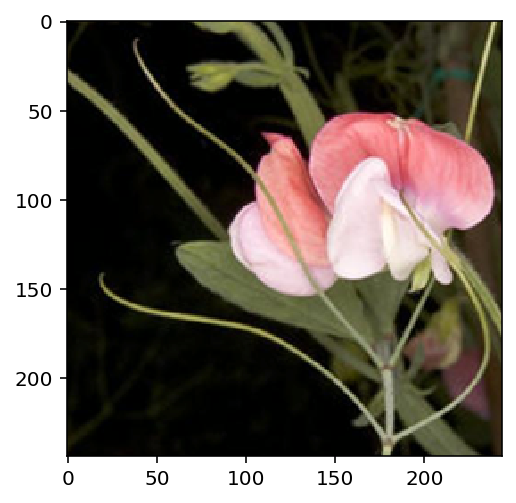

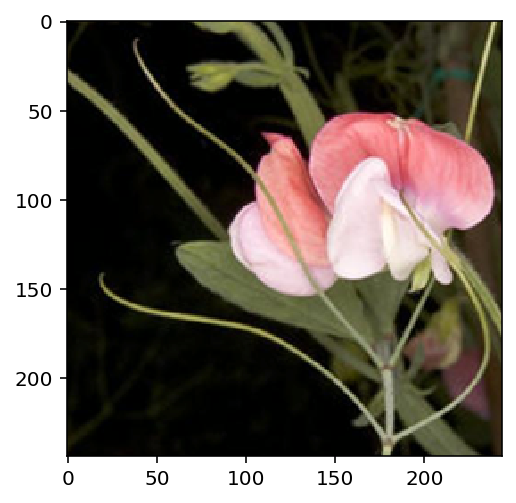

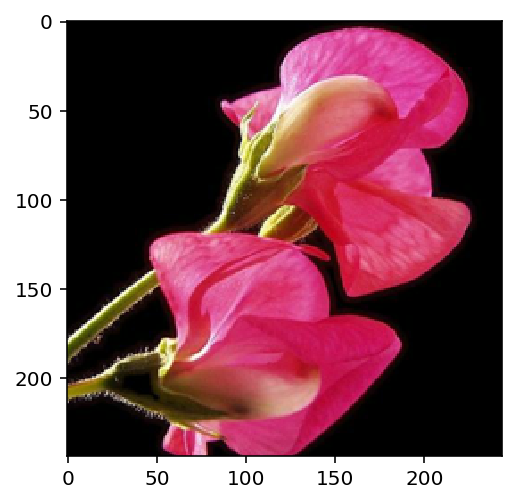

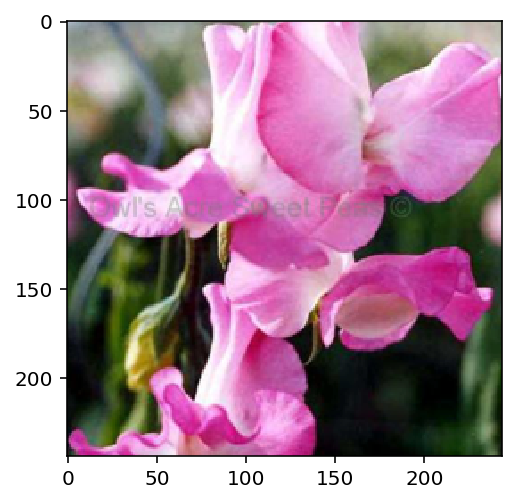

In [24]:
# Test functions on an example
files = glob.glob(test_dir + "*/4/*.jpg")
images = [random.choice(files) for _ in range(4)]

for image_path in images:
    processed_image = process_image(image_path)
    imshow(processed_image)

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [25]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [label_map[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

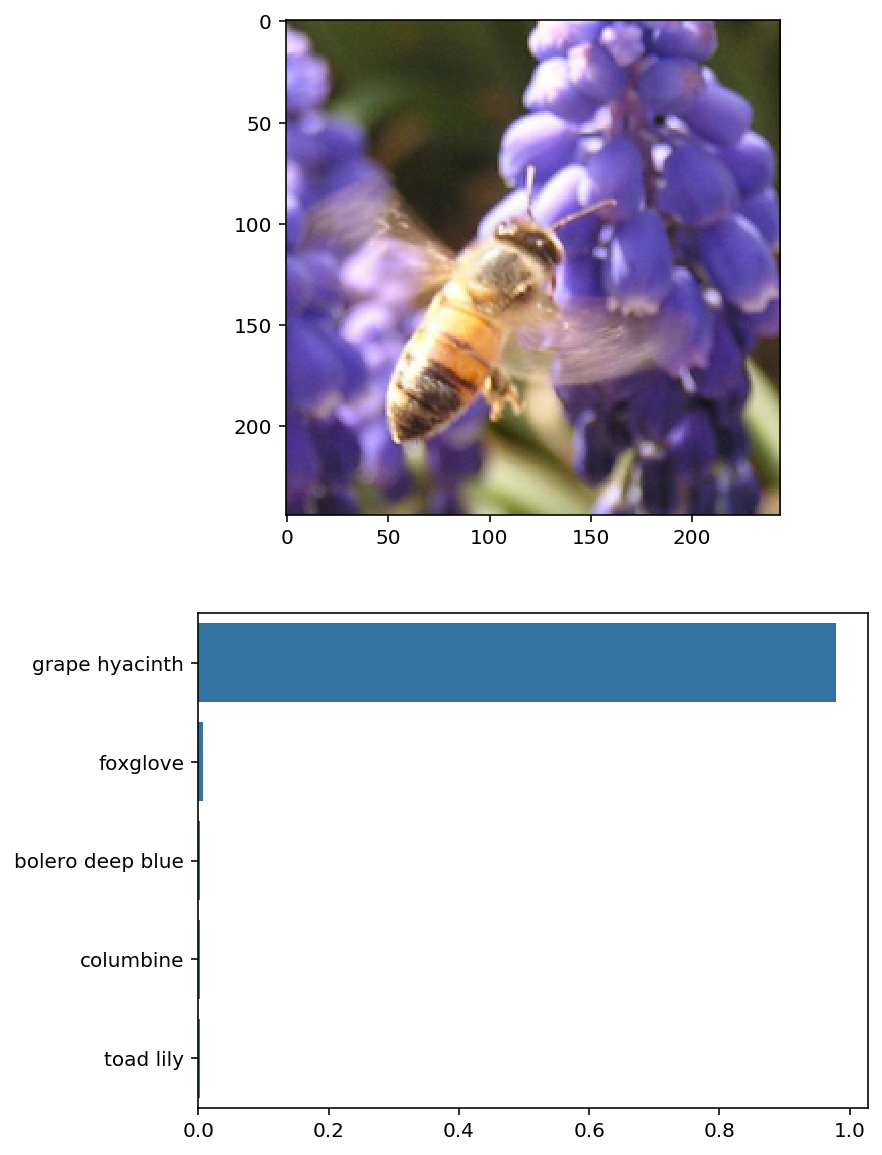

In [26]:
# TODO: Display an image along with the top 5 classes
# Define image path
image_path = "flowers/test/25/image_06583.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = label_map[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
seaborn.barplot(x=probs, y=flowers, color=seaborn.color_palette()[0]);
plt.show()

In [27]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Project_Image_Classifier.ipynb to html',
 '[NbConvertApp] Writing 1603790 bytes to Project_Image_Classifier.html',
 '[NbConvertApp] Converting notebook Project_Image_Classifier_Project.ipynb to html',
 '[NbConvertApp] Writing 393120 bytes to Project_Image_Classifier_Project.html',
 '[NbConvertApp] Converting notebook Project_Image_Classifier_Project-new.ipynb to html',
 '[NbConvertApp] Writing 871588 bytes to Project_Image_Classifier_Project-new.html']